<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr2/blob/main/Kulinichenko%20Alexander/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5_2_%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%B0_01_04_2023_%D0%9A%D1%83%D0%BB%D0%B8%D0%BD%D0%B8%D1%87%D0%B5%D0%BD%D0%BA%D0%BE_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B1%D0%B0%D0%B7%D1%8B_21_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Анализ резюме: Система HR-рекомендаций. (INSPECTRUM CLINIC)**

**Цель:** Текст, выделенный полужирным шрифтом
Разработать прототип системы, реализующей функцию рекомендательной системы для HR-специалиста.

**Принцип работы:**
Система должна помогать HR-специалисту вынести решение о том, подходит или не подходит человек на рассматриваемую должность.
В датасете целевым столбцом для предсказания является столбец под названием “Подходит - да/нет”.
Результатом работы обученной нейросети должно служить дополнение датасета столбцом под названием “оценка резюме”, где должно быть представлено процентное распределение вероятностей между классами “подходит” и “не подходит”. Например: "подходит 95% / не подходит 5%".
Система должна иметь возможность дообучаться на новых данных, предоставленных Заказчиком.

**Требования к скорости работы:**
Не предъявляются

**Требования к тестированию, метрикам качества:**
Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.



#Загрузка Библиотек

In [1]:
# установка autokeras
!pip install autokeras

In [2]:
# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split # Для разбивки на выборки

# Импорт метода построения confusion_matrix
from sklearn.metrics import confusion_matrix
# Импорт метода визуализации confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import seaborn as sns


#использовать библиотеку OpenXML SDK
import openpyxl

%matplotlib inline

In [ ]:
pip list

#Загрузка датасета

In [ ]:

# Загрузка файла из облака в colab
#старый датасет
#pact_file = "https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_HR/datasets/%D0%94%D0%B0%D1%82%D0%B0%D0%A1%D0%B5%D1%82%20%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0%20%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5%20581%20%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5.xlsx"

#Новый датасет
pact_file = "https://docs.google.com/spreadsheets/d/17XEUVjDEsRNhaQCzvv2XCdzy3y1JCHVQ/edit?usp=sharing&ouid=112820216299626003794&rtpof=true&sd=true"

#pact_file = "/content/drive/MyDrive/Colab Notebooks/1 стажировка резюме 01.04.2023/ДатаСет_Оценка_резюме_581_резюме_3_0_без_оценки.xlsx"

gdown.download(pact_file, None, quiet=True)
data_xsl = pd.read_excel(pact_file, sheet_name='Лист1')
#data_xsl = pd.read_excel(pact_file, sheet_name='Лист1', engine='openpyxl')

data_xsl.head()



In [9]:
#загрузка файла с компьютера
from google.colab import files
upload = files.upload()

Saving ДатаСет_Оценка_резюме_581_резюме_3_0_без_оценки.xlsx to ДатаСет_Оценка_резюме_581_резюме_3_0_без_оценки.xlsx


In [10]:
import io
data_xsl= pd.read_excel(io.BytesIO(upload['ДатаСет_Оценка_резюме_581_резюме_3_0_без_оценки.xlsx']))
data_xsl.head()

,Unnamed: 0,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да


# Изучение датасета

In [ ]:
#количество строк и столбцов
data_xsl.shape

(579, 17)

In [ ]:
#Проверка на непустые (заполненые) поля
data_xsl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Unnamed: 0                                  579 non-null    int64 
 1   Дата отклика                                579 non-null    object
 2   Пол, возраст                                579 non-null    object
 3   ЗП                                          579 non-null    object
 4   Ищет работу на должность                    579 non-null    object
 5   Город                                       579 non-null    object
 6   Занятость                                   579 non-null    object
 7   График                                      579 non-null    object
 8   Опыт ()                                     579 non-null    object
 9   Последнее/нынешное место работы             579 non-null    object
 10  Последняя/нынешняя должнос

In [ ]:
#Сколько пропущенных значений (не заполненых полей) по колонкам
print(data_xsl.isna().sum())

Unnamed: 0                                      0
Дата отклика                                    0
Пол, возраст                                    0
ЗП                                              0
Ищет работу на должность                        0
Город                                           0
Занятость                                       0
График                                          0
Опыт ()                                         0
Последнее/нынешное место работы                 0
Последняя/нынешняя должность                    0
Выполняемые задачи на прошлых местах работ     27
Обо мне                                       135
Ключевые навыки                                47
Образование и ВУЗ                               0
Обновление резюме                               0
Подходит - да/нет                              79
dtype: int64


In [ ]:
#Сграппируем данные сначала по Ищет работу на должность, а затем по 'Подходит - да/нет'
data_ =data_xsl.groupby(['Ищет работу на должность', 'Подходит - да/нет']).count()
data_.head(50)

Unnamed: 0  \
Ищет работу на должность                           Подходит - да/нет               
Growth Product Manager                             да                          5   
                                                   нет                       179   
HR-специалист                                      да                          4   
                                                   нет                       111   
Product Manager в команду HR                       нет                        13   
Product Manager в команду Финансового департамента нет                        25   
Product Marketing Manager в Growth Hacking команду нет                         6   
Product manager в Growth Hacking команду           да                          1   
                                                   нет                        55   
Project manager                                    нет                         8   
Директор медицинской клиники                       да                          1   
                                                   нет                        92   

                                                                      Дата отклика  \
Ищет работу на должность                           Подходит - да/нет                 
Growth Product Manager                             да                            5   
                                                   нет                         179   
HR-специалист                                      да                            4   
                                                   нет                         111   
Product Manager в команду HR                       нет                          13   
Product Manager в команду Финансового департамента нет                          25   
Product Marketing Manager в Growth Hacking команду нет                           6   
Product manager в Growth Hacking команду           да                            1   
                                                   нет                          55   
Project manager                                    нет                           8   
Директор медицинской клиники                       да                            1   
                                                   нет                          92   

                                                                      Пол, возраст  \
Ищет работу на должность                           Подходит - да/нет                 
Growth Product Manager                             да                            5   
                                                   нет                         179   
HR-специалист                                      да                            4   
                                                   нет                         111   
Product Manager в команду HR                       нет                          13   
Product Manager в команду Финансового департамента нет                          25   
Product Marketing Manager в Growth Hacking команду нет                           6   
Product manager в Growth Hacking команду           да                            1   
                                                   нет                          55   
Project manager                                    нет                           8   
Директор медицинской клиники                       да                            1   
                                                   нет                          92   

                                                                       ЗП  \
Ищет работу на должность                           Подходит - да/нет        
Growth Product Manager                             да                   5   
                                                   нет                179   
HR-специалист                                      да                   4   
                                                   нет                111   
Product Manager в ком

In [ ]:
#Группируем данные по колонке 'Ищет работу на должность' и находим количество да и нет по каждой позиции
#print( data_xsl.groupby('Ищет работу на должность')['Подходит - да/нет'].nunique().sum())
#print( data_xsl.groupby('Ищет работу на должность')['Подходит - да/нет'].sum())
print( data_xsl.groupby('Ищет работу на должность')['Подходит - да/нет'].value_counts())

Ищет работу на должность                            Подходит - да/нет
Growth Product Manager                              нет                  179
                                                                          14
                                                    да                     5
HR-специалист                                       нет                  111
                                                    да                     4
Product Manager в команду HR                        нет                   13
                                                                          12
Product Manager в команду Финансового департамента  нет                   25
                                                                          11
Product Marketing Manager в Growth Hacking команду                         8
                                                    нет                    6
Product manager в Growth Hacking команду            нет                   55
      

In [ ]:
#Группируем данные по колонке 'Ищет работу на должность' и "Подходит - да/нет" затем находим количество да и нет по каждой позиции
data_xsl[data_xsl["Подходит - да/нет"].notna()].groupby(["Ищет работу на должность", "Подходит - да/нет"])["Подходит - да/нет"].count()

Ищет работу на должность                            Подходит - да/нет
Growth Product Manager                                                    14
                                                    да                     5
                                                    нет                  179
HR-специалист                                       да                     4
                                                    нет                  111
Product Manager в команду HR                                              12
                                                    нет                   13
Product Manager в команду Финансового департамента                        11
                                                    нет                   25
Product Marketing Manager в Growth Hacking команду                         8
                                                    нет                    6
Product manager в Growth Hacking команду                                  21
      

In [ ]:
# Заменяем все NaN значения на """
data_xsl.fillna("", inplace=True)
data_xsl.head()

,Unnamed: 0,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да


In [ ]:
# Смотрим количество слов в колонках

# Функция для подсчета минимального значения слов
def min_words(text):
    words = text.split()
    if len(words) == 0:
        return 0
    else:
        return len(min(words, key=len))

# Функция для подсчета максимального значения слов
def max_words(text):
    words = text.split()
    if len(words) == 0:
        return 0
    else:
        return len(max(words, key=len))

# Функция для подсчета среднего значения слов
def avg_words(text):
    words = text.split()
    if len(words) == 0:
        return 0
    else:
        return sum(len(word) for word in words) / len(words)

# Применяем функции к колонке 'Обо мне' и сохраняем результаты в новые колонки 'Минимальное количество слов', 'Максимальное количество слов' и 'Среднее количество слов'
#data_xsl['Минимальное количество слов'] = data_xsl['Обо мне'].apply(min_words)
#data_xsl['Максимальное количество слов'] = data_xsl['Обо мне'].apply(max_words)
#data_xsl['Среднее количество слов'] = data_xsl['Обо мне'].apply(avg_words)

# Выводим итоговую таблицу
print("Колонка Выполняемые задачи на прошлых местах работ")
print(min(data_xsl['Выполняемые задачи на прошлых местах работ'].apply(min_words)))
print(max(data_xsl['Выполняемые задачи на прошлых местах работ'].apply(max_words)))
print(data_xsl['Выполняемые задачи на прошлых местах работ'].apply(avg_words).mean())
print()
print("Колонка обо мне")
print(min(data_xsl['Обо мне'].apply(min_words)))
print(max(data_xsl['Обо мне'].apply(max_words)))
#print(data_xsl['Обо мне'].apply(max_words).max())
print(data_xsl['Обо мне'].apply(avg_words).mean())
print()
print("Колонка Ключевые навыки")
print(min(data_xsl['Ключевые навыки'].apply(min_words)))
print(max(data_xsl['Ключевые навыки'].apply(max_words)))
print(data_xsl['Ключевые навыки'].apply(avg_words).mean())
print()
print("Собранные 3 колонки вместе")
print((data_xsl['Выполняемые задачи на прошлых местах работ'].astype(str) + data_xsl['Обо мне'].astype(str) + data_xsl['Ключевые навыки'].astype(str)).apply(min_words).min())
print((data_xsl['Выполняемые задачи на прошлых местах работ'].astype(str) + data_xsl['Обо мне'].astype(str) + data_xsl['Ключевые навыки'].astype(str)).apply(max_words).max())
print((data_xsl['Выполняемые задачи на прошлых местах работ'].astype(str) + data_xsl['Обо мне'].astype(str) + data_xsl['Ключевые навыки'].astype(str)).apply(avg_words).mean())
print()
print("Колонка Образование и ВУЗ")
print(min(data_xsl['Образование и ВУЗ'].apply(min_words)))
print(max(data_xsl['Образование и ВУЗ'].apply(max_words)))
print(data_xsl['Образование и ВУЗ'].apply(avg_words).mean())
print()
print("Собранные 4 колонки вместе")
print((data_xsl['Выполняемые задачи на прошлых местах работ'].astype(str) + data_xsl['Обо мне'].astype(str) + data_xsl['Ключевые навыки'].astype(str) + data_xsl['Образование и ВУЗ'].astype(str)).apply(min_words).min())
print((data_xsl['Выполняемые задачи на прошлых местах работ'].astype(str) + data_xsl['Обо мне'].astype(str) + data_xsl['Ключевые навыки'].astype(str) + data_xsl['Образование и ВУЗ'].astype(str)).apply(max_words).max())
print((data_xsl['Выполняемые задачи на прошлых местах работ'].astype(str) + data_xsl['Обо мне'].astype(str) + data_xsl['Ключевые навыки'].astype(str) + data_xsl['Образование и ВУЗ'].astype(str)).apply(avg_words).mean())
print()

Колонка Выполняемые задачи на прошлых местах работ
0
111
6.827779553124331

Колонка обо мне
0
254
5.790677960861705

Колонка Ключевые навыки
0
46
8.079885580321175

Собранные 3 колонки вместе
0
254
7.089434128106076

Колонка Образование и ВУЗ
1
29
8.807203190207725

Собранные 4 колонки вместе
1
254
7.535289503104973



In [ ]:
data_xsl_ = data_xsl.groupby(['Ищет работу на должность']).count()
#data_xsl_ = data_xsl.groupby(['ЗП']).count()
#data_xsl_ = data_xsl.groupby(['Занятость']).count()
#data_xsl_ = data_xsl.groupby(['График']).count()
#data_xsl_ = data_xsl.groupby(['Опыт ()']).count()
#data_xsl_ = data_xsl.groupby(['Последняя/нынешняя должность']).count()
#data_xsl_ = data_xsl.groupby(['Подходит - да/нет']).count()
data_xsl_

,Unnamed: 0,Дата отклика,"Пол, возраст",ЗП,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
Ищет работу на должность,,,,,,,,,,,,,,,,
Growth Product Manager,198,198,198,198,198,198,198,198,198,198,190,163,183,198,198,184
HR-специалист,115,115,115,115,115,115,115,115,115,115,109,76,103,115,115,115
Product Manager в команду HR,25,25,25,25,25,25,25,25,25,25,22,19,22,25,25,13
Product Manager в команду Финансового департамента,36,36,36,36,36,36,36,36,36,36,35,26,31,36,36,25
Product Marketing Manager в Growth Hacking команду,14,14,14,14,14,14,14,14,14,14,14,13,14,14,14,6
Product manager в Growth Hacking команду,77,77,77,77,77,77,77,77,77,77,75,66,75,77,77,56
Project manager,21,21,21,21,21,21,21,21,21,21,21,15,21,21,21,8
Директор медицинской клиники,93,93,93,93,93,93,93,93,93,93,86,66,83,93,93,93


In [ ]:
#количество уникальных значений, самое часто встречающееся значение и его частота для каждого столбца с текстовыми данными.
data_xsl.describe(include=['O'])

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
count,579,579,579,579,579,579,579,579,579,579,552,444,532,579,579,500
unique,89,443,44,8,209,20,30,252,486,358,548,418,479,488,547,2
top,2023-02-22 00:00:00,Женщина,не указана,Growth Product Manager,"Уфа, Не готова к переезду, не готова к команди...",полная занятость,полный день,Опыт работы —6 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product manager,Управлял тремя отдельными блокчейн-проектами с...,"Стрессоустойчивый, энергичный, нацелен на резу...",Обучаемость,Среднее образование,31 января 2023 в 09:52,нет
freq,48,41,288,198,69,342,202,10,12,42,2,3,9,15,3,489


In [33]:
data_xsl["Город"].value_counts()

уфа, не готова к переезду, не готова к командировкам                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              71
уфа, не готова к переезду, готова к редким командировкам                                           

In [37]:
data_xsl["Город"].nunique()

204

In [35]:
# рассмотрим содержимое колонки соискателя должности
data_xsl["Ищет работу на должность"].unique()

array(['growth product manager',
       'product manager в growth hacking команду',
       'директор медицинской клиники', 'hr-специалист',
       'product manager в команду финансового департамента',
       'product manager в команду hr', 'project manager',
       'product marketing manager в growth hacking команду'], dtype=object)

In [38]:
data_xsl["Ищет работу на должность"].nunique()

8

#Предварительные выводы:
0. Номер по порядку
1. дата отклика
2. Пол, возраст.  ЗАМЕЧАНИЕ: Не у всех заполнен возраст и дата рождения
3. ЗП. ЗАМЕЧАНИЕ: У некоторых не указана. Есть в различной валюте
4. Ищет работу на должность. ЗАМЕЧАНИЕ: Всего 8 позиций
5. Город. ЗАМЕЧАНИЕ: У некоторых всесто города указана страна. так же в этом поле информация готов, неготов к переезду, командировкам
6. Занятость. ЗАМЕЧАНИЕ: Всего 20 разновидностей заполнения (из 5 возможных)типа: полная занятость, частичная занятость, проектная работа, стажировка, волонтерство
7. График.  ЗАМЕЧАНИЕ: Всего 30 вариантов заполнения ( из 5 возможных) типа вахтовый метод, удаленная работа (удаленная), гибкий график, полный день, сменный график. Также ошибки типа: "сменный графи", "удаленная работа\n\n". Из за чего увеличиваются варианты заполнения.
8. Опыт (). ЗАМЕЧАНИЕ: указывается количество лет и месяцев
9. Последнее/нынешное место работы.
10. Последняя/нынешняя должность.
11. Выполняемые задачи на прошлых местах работ
12. Обо мне
13. Ключевые навыки
14. Образование и ВУЗ. Замечание Образование (12 вариантов есть повторяющиеся)
15. Обновление резюме.
16. Подходит - да/нет.  ЗАМЕЧАНИЕ: Да - 11, НЕТ - 489, Не запполнено - 79. По данному столбцу база разбалансировна. Только у "Growth Product Manager" (5 да и 179 нет) и "HR-специалист" (4 да и 111 нет) есть положительные решения. У "Product manager в Growth Hacking команду" и "Директор медицинской клиники" есть по 1 положительному решению. У остальных положительных решений нет.

Предварительно можно провести обучение только по двум позициям где есть положительные решения.


# Изменение базы (удаление лишних символов, приведение к нижнему регистру)

In [11]:
# Заменяем все NaN значения на """  аналогичная функция в модуле Изучение датасета если запускали там то здесь не надо
data_xsl.fillna("", inplace=True)
data_xsl.head()

,Unnamed: 0,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да


In [12]:
data_xsl = data_xsl.drop(data_xsl.columns[0],axis = 1) # Убираем первый столбец с продублированными индексами. Он нам не нужен

In [13]:

# Замена концов строк на пробелы, удаление символа с кодом 0xA0
# обрезка краевых пробелов, приведение к нижнему регистру
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

data_xsl = data_xsl.applymap(purify)
data_xsl.head()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,2023-02-23 00:00:00,женщина,90 000 руб.,growth product manager,"индонезия, не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,опыт работы —5 лет 10 месяцев,pt mybali app group,менеджер по продукту,маркетинговые исследования исследование рынка;...,,анализ рынка управление проектами product mana...,"высшее, 2023, нетоло́гия, 2014, университет ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,женщина,не указана,growth product manager,"москва, готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",опыт работы —11 лет 11 месяцев,банк открытие,product owner трайб сбережения и инвестиции,участие в команде роста в2в задачи: - развити...,,самомотивация таймменеджмент креативность чувс...,"высшее, 2022, geekbrains, 2010, московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"мужчина, 33 года, родился 23 августа 1989",150 000 руб.,growth product manager,"санкт-петербург, готов к переезду: москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",опыт работы —7 лет 2 месяца,dikiy llc,,запуск бренда и производства игристого кваса d...,"чем бы я ни занимался с 2014 года, когда решил...",продвижение бренда планирование маркетинговых ...,"высшее, 2013, санкт-петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"мужчина, 32 года, родился 7 декабря 1990",не указана,growth product manager,"москва, м. молодежная, хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",опыт работы —8 лет 10 месяцев,weinvest,product manager (team leader),1. исследование рынка 2. определение целевой а...,"я проактивный, коммуникабельный, позитивный, д...",управление проектами организаторские навыки пр...,"магистр, 2014, московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,growth product manager,"пермь, хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",опыт работы —5 лет 9 месяцев,индивидуальное предпринимательство / частная п...,product/project manager,"переговоры со стейкхолдером - составление тз, ...",набрал кучу опыта и хочу с ним найти классную ...,управление персоналом заключение договоров ана...,"высшее, 2021, российская академия народного хо...",6 февраля 2023 в 11:18,да


# Проверка базы для подготовки классификаторов

In [ ]:
# Разбор значений пола (вариант от елены соколовой измененный для проверки если нет указания на мужчина это или женщина)
def extract_gender(arg):
    if 'женщина' in arg.lower():
        return 0
    elif 'мужчина' in arg.lower():
        return 1
    else:
        return "2"    # указатель что не указано мужчина или женщина

columns =['Пол', 'возраст']
data_clean = pd.DataFrame(data=None, index=None, columns=columns, dtype=None)
data_clean['Пол'] = data_xsl['Пол, возраст'].apply(extract_gender)

#data_clean
data_clean['Пол'].value_counts()
#Если нет двоек то все хорошо


1    302
0    277
Name: Пол, dtype: int64

In [ ]:
# Разбор значений возраста ( эта часть функции из раздела Парсинг базы выбирает только вохраст)

base_update_year = 2023

def extract_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    #sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return years

#columns =['Пол', 'возраст']
#data_clean = pd.DataFrame(data=None, index=None, columns=columns, dtype=None)
data_clean['возраст'] = data_xsl['Пол, возраст'].apply(extract_age_years)

#data_clean
#data_clean['возраст'].value_counts()
data_clean.agg(['sum', 'mean', 'min', 'max'])

,Пол,возраст
sum,302.000000,16892.000000
mean,0.521589,29.174439
min,0.000000,0.000000
max,1.000000,60.000000


In [ ]:
# Разбор значений возраста (2 вариает)
def extract_age(arg):
    year_key_words = ['год', 'лет', 'года']
    args_splited = arg.split(',')[:2]
    if len(args_splited) > 1:
        year = int(re.findall(r'\d+', args_splited[1])[0])
    else:
        year = 0
    return year


data_clean['возраст2'] = data_xsl['Пол, возраст'].apply(extract_age)
#data_clean['возраст2'].value_counts()
data_clean.agg(['sum', 'mean', 'min', 'max'])
# !!! Подсчет возраста отличается

,Пол,возраст,возраст2
sum,302.000000,16892.000000,16475.000000
mean,0.521589,29.174439,28.454231
min,0.000000,0.000000,0.000000
max,1.000000,60.000000,60.000000


In [ ]:
# Курсы валют для зарплат
currency_rate = {'руб'    : 1.,
                 'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Разбор значения зарплаты
#!!! (данная функция есть в главе "Парсинг базы")
def extract_salary_test(arg):
    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        try:
            # Выделение числа и преобразование к float
            num = float(re.search(r'\d+', num)[0])

            # Поиск символа валюты в строке, и, если найдено,
            # приведение к рублю по курсу валюты
            for currency, rate in currency_rate.items():
                if currency in arg :
                    num *= rate
                    break
            else:
                print("Неизвестная валюта:", arg)

        except TypeError:
            # Если не получилось выделить число - вернуть 0
            num = 0.

    return round(num / 1000, 0)                  # В тысячах рублей

data_clean['ЗП'] = data_xsl['ЗП'].apply(extract_salary_test)
#data_clean
#data_clean['ЗП'].value_counts()
data_clean.agg(['sum', 'mean', 'min', 'max'])

Неизвестная валюта: 1 900 000 KZT
Неизвестная валюта: 600 000 KZT
Неизвестная валюта: 1 550 USD
Неизвестная валюта: 1 200 EUR
Неизвестная валюта: 2 500 USD
Неизвестная валюта: 4 000 USD
Неизвестная валюта: 2 000 USD
Неизвестная валюта: 3 500 USD
Неизвестная валюта: 1 550 USD
Неизвестная валюта: 100 000 KGS
Неизвестная валюта: 2 000 USD
Неизвестная валюта: 3 000 USD


NameError: ignored

In [ ]:
#Находим все варианты валют столбце ЗП
unique_currency = []

i=0
for i in range(data_xsl.shape[0]): # По всему столбцу резюме
    if type(data_xsl.loc[i, 'ЗП'])!=float:
        values = data_xsl.loc[i, 'ЗП']
        values = values.split(",")
        for value in values:
            value = re.sub(' ','',value)
            value = re.sub('[0-9]','',value)
            value = value.strip()
            if value not in unique_currency:
                unique_currency.append(value)

print(unique_currency)
print(len(unique_currency))



['руб.', 'неуказана', 'kzt', 'usd', 'eur', 'руб', 'kgs']
7


In [ ]:
#Находим все варианты в столбце Ищет работу на должность
unique_job_title = []

i=0
for i in range(data_xsl.shape[0]): # По всему столбцу резюме
    if type(data_xsl.loc[i, 'Ищет работу на должность'])!=float:
        values = data_xsl.loc[i, 'Ищет работу на должность']
        values = values.split(",")
        for value in values:
            value = value.strip()
            if value not in unique_job_title:
                unique_job_title.append(value)

print(unique_job_title)
print(len(unique_job_title))

['growth product manager', 'product manager в growth hacking команду', 'директор медицинской клиники', 'hr-специалист', 'product manager в команду финансового департамента', 'product manager в команду hr', 'project manager', 'product marketing manager в growth hacking команду']
8


In [ ]:
#Находим все варианты в столбце Занятость
unique_employment = []

i=0
for i in range(data_xsl.shape[0]): # По всему столбцу резюме
    if type(data_xsl.loc[i, 'Занятость'])!=float:
        values = data_xsl.loc[i, 'Занятость']
        values = values.split(",")
        for value in values:
            value = value.strip()
            if value not in unique_employment:
                unique_employment.append(value)

print(unique_employment)
print(len(unique_employment))

['проектная работа', 'частичная занятость', 'полная занятость', 'стажировка', 'волонтерство', 'неполный рабочий день', 'полный рабочий день']
7


In [ ]:
#Находим все варианты в столбце График
unique_schedule = []

i=0
for i in range(data_xsl.shape[0]): # По всему столбцу резюме
    if type(data_xsl.loc[i, 'График'])!=float:
        values = data_xsl.loc[i, 'График']
        values = values.split(",")
        for value in values:
            value = value.strip()
            if value not in unique_schedule:
                unique_schedule.append(value)

print(unique_schedule)
print(len(unique_schedule))

['удаленная работа', 'гибкий график', 'полный день', 'сменный график', 'вахтовый метод', 'полный рабочий день', 'удаленная', 'сменный графи']
8


In [ ]:
#Находим все варианты образования в столбце Образование и ВУЗ
unique_education = []

i=0
for i in range(data_xsl.shape[0]): # По всему столбцу резюме
    if type(data_xsl.loc[i, 'Образование и ВУЗ'])!=float:
        values = data_xsl.loc[i, 'Образование и ВУЗ']
        values = values.split(",")[0]
        values = values.strip()
        if values not in unique_education:
            unique_education.append(values)

print(unique_education)
print(len(unique_education))



['высшее', 'магистр', 'среднее специальное', 'бакалавр', 'неоконченное высшее', 'доктор наук', 'кандидат наук', 'среднее образование', 'среднее специальное образование', 'незаконченное высшее образование', 'высшее образование', 'среднее']
12


In [ ]:
#Находим все варианты городов, стран (первое вхождение) в столбце Город
unique_city = []
millionCities_lst = "Москва, Санкт-Петербург, Новосибирск, Екатеринбург, Нижний Новгород, Казань, Челябинск, Омск, Самара, Ростов-на-Дону, Уфа, Красноярск, Пермь, Воронеж, Волгоград,"
i=0
for i in range(data_xsl.shape[0]): # По всем резюме
    if type(data_xsl.loc[i, 'Город'])!=float:
        values = data_xsl.loc[i, 'Город']
        values = values.split(",")[0]
        values = values.strip()
        if values not in millionCities_lst.lower():
           if values not in unique_city:
                unique_city.append(values)

unique_city.sort()
print(unique_city)
print(len(unique_city))

['актау', 'алматы', 'армения', 'астана', 'астрахань', 'батуми', 'бишкек', 'брянск', 'германия', 'ижевск', 'израиль', 'индия', 'индонезия', 'иркутск', 'йошкар-ола', 'караганда', 'кемерово', 'киров (кировская область)', 'кишинёв', 'кострома', 'краснодар', 'кумертау', 'магнитогорск', 'минск', 'мурманск', 'набережные челны', 'оаэ', 'октябрьский (республика башкортостан)', 'саратов', 'саров', 'сербия', 'сочи', 'стерлитамак', 'таиланд', 'ташкент', 'тбилиси', 'тольятти', 'томск', 'тула', 'турция', 'тюмень', 'ульяновск', 'щелково', 'энгальс', 'ярославль']
45


In [89]:
#Находим все варианты перездов (второе вхождение) в столбце Город
unique_moving = []

i=0
for i in range(data_xsl.shape[0]): # По всему столбцу резюме
    if type(data_xsl.loc[i, 'Город'])!=float:
        values = data_xsl.loc[i, 'Город']
        values = values.split(",")[1:-1]
        for value in values:
            value = value.strip()
            if value not in unique_moving:
                unique_moving.append(value)

unique_moving.sort()
print(unique_moving)
print(len(unique_moving))

['австралия', 'австрия', 'азербайджан', 'албания', 'алжир', 'андорра', 'аргентина', 'армения', 'астана', 'астраханская область', 'багамские острова', 'баку', 'бангладеш', 'бахрейн', 'бельгия', 'бишкек', 'болгария', 'босния и герцеговина', 'бразилия', 'великобритания', 'венгрия', 'венесуэла', 'владивосток', 'вьетнам', 'германия', 'готов к переезду', 'готов к переезду: абхазия', 'готов к переезду: алматы', 'готов к переезду: беларусь', 'готов к переезду: другие регионы', 'готов к переезду: израиль', 'готов к переезду: кипр', 'готов к переезду: китай', 'готов к переезду: кыргызстан', 'готов к переезду: москва', 'готов к переезду: нидерланды', 'готов к переезду: оаэ', 'готов к переезду: республика крым', 'готов к переезду: россия', 'готов к переезду: санкт-петербург', 'готов к переезду: симферополь', 'готов к переезду: сша', 'готов к переезду: тбилиси', 'готов к переезду: ярославль', 'готова к переезду', 'готова к переезду (уфа)', 'готова к переезду: другие регионы', 'готова к переезду: мо

In [87]:
#Находим все варианты перездов (второе вхождение) в столбце Город
unique_moving_1 = []

i=0
for i in range(data_xsl.shape[0]): # По всему столбцу резюме
    if type(data_xsl.loc[i, 'Город'])!=float:
        values = data_xsl.loc[i, 'Город']
        values = values.split(",")
        value = ', '.join(values[1:-1]).strip()
        if value not in unique_moving_1:
            unique_moving_1.append(value)

unique_moving_1.sort()
print(unique_moving_1)
print(len(unique_moving_1))

['готов к переезду', 'готов к переезду: абхазия,  индия,  австралия,  грузия,  армения,  турция', 'готов к переезду: алматы,  израиль,  узбекистан,  тбилиси,  ташкент,  бишкек,  кипр,  армения,  оаэ,  сербия,  баку,  турция,  астана', 'готов к переезду: алматы,  москва,  санкт-петербург,  сербия,  тбилиси,  кипр', 'готов к переезду: беларусь,  кыргызстан,  узбекистан,  россия,  казахстан,  азербайджан,  другие регионы,  грузия', 'готов к переезду: беларусь,  оаэ,  елабуга,  санкт-петербург,  великобритания,  испания,  казань,  набережные челны,  германия,  кипр,  турция', 'готов к переезду: другие регионы', 'готов к переезду: израиль,  ирландия,  франция,  италия,  австрия,  чехия,  исландия,  норвегия,  россия,  сербия,  иран,  великобритания,  хорватия,  германия', 'готов к переезду: кипр', 'готов к переезду: китай,  сша,  таиланд', 'готов к переезду: кыргызстан,  узбекистан,  украина,  казахстан,  азербайджан,  другие регионы,  грузия', 'готов к переезду: москва', 'готов к переезду:

In [88]:
#Находим все варианты командировок  (последнее (третье) вхождение) в столбце Город
unique_business_trips = []

i=0
for i in range(data_xsl.shape[0]): # По всему столбцу резюме
    if type(data_xsl.loc[i, 'Город'])!=float:
        values = data_xsl.loc[i, 'Город']
        values = values.split(",")
        value = values[-1].strip()
        if value not in unique_business_trips:
            unique_business_trips.append(value)

unique_business_trips.sort()
print(unique_business_trips)
print(len(unique_business_trips))

['', 'готов к деловым поездкам', 'готов к командировкам', 'готов к редким командировкам', 'готова к командировкам', 'готова к редким командировкам', 'готовлюсь к командировкам', 'не готов к командировкам', 'не готова к командировкам']
9


# Классификаторы (списки, словари)

In [14]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {'руб'    : 1.,
                 'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0,
              {'германия'        : 0,
               'израиль'         : 0,
               'индия'           : 0,
               'индонезия'       : 0,
               'оаэ'             : 0,
               'сербия'          : 0,
               'таиланд'         : 0,
               'турция'          : 0,
               'актау'           : 1,
               'алматы'          : 1,
               'армения'         : 1,
               'астана'          : 1,
               'батуми'          : 1,
               'бишкек'          : 1,
               'караганда'       : 1,
               'кишинёв'         : 1,
               'минск'           : 1,
               'ташкент'         : 1,
               'тбилиси'         : 1,
               'москва'          : 2,
               'санкт-петербург' : 3,
               'новосибирск'     : 4,
               'екатеринбург'    : 4,
               'нижний новгород' : 4,
               'казань'          : 4,
               'челябинск'       : 4,
               'омск'            : 4,
               'самара'          : 4,
               'ростов-на-дону'  : 4,
               'уфа'             : 4,
               'красноярск'      : 4,
               'пермь'           : 4,
               'воронеж'         : 4,
               'волгоград'       : 4,
               'прочие города'   : 5
              }]

# Классы занятости
employment_class = [0,
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'неполный рабочий день' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3,
                     'полный рабочий день' : 3,
                     'волонтерство'        : 4,
                    }]

# Классы графика работы
schedule_class = [0,
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'полный рабочий день'   : 1,
                   'сменный график'        : 2,
                   'сменный'               : 2,
                   'удаленная работа'      : 3,
                   'удаленная'             : 3,
                   'вахтовый метод'        : 4
                  }]

# Классы образования
education_class = [0,
                   {'доктор наук'          : 0,
                    'кандидат наук'        : 0,
                    'высшее образование'   : 1,
                    'higher education'     : 1,
                    'высшее'               : 1,
                    'магистр'              : 1,
                    'бакалавр'             : 1,
                    'незаконченное высшее образование'  : 2,
                    'неоконченное высшее'  : 2,
                    'среднее специальное'  : 3,
                    'среднее специальное образование'  : 3,
                    'среднее            '  : 4,
                    'среднее образование'  : 4
                   }]

# Классы целевой должности.
pos_class = [10,
                    {'прочее'                                              : 0,
                     'Product Manager'                                     : 1,
                     'Growth Product Manager'                              : 2,
                     'Product Marketing Manager в Growth Hacking команду'  : 3,
                     'Product manager в Growth Hacking команду'            : 4,
                     'HR-специалист'                                       : 5,
                     'Product Manager в команду HR'                        : 6,
                     'Project manager'                                     : 7,
                     'Директор медицинской клиники'                        : 8,
                     'Product Manager в команду Финансового департамента'  : 9
                    }]



# Парсинг базы

## Создание ограниченной выборки
Выбор из базы только позиций 'Growth Product Manager' и  'HR-специалист' для обучения

In [15]:
# Выбор 'Growth Product Manager' и  'HR-специалист' сюда попажают и пустые значения колонки 'Подходит - да/нет'
from functools import reduce
FILTER_CONDITIONS = [
    data_xsl['Ищет работу на должность']== 'Growth Product Manager',
    data_xsl['Ищет работу на должность']== 'HR-специалист',
]
data = (data_xsl.loc[reduce(lambda x, y: x | y, FILTER_CONDITIONS)]
)
#data = data_xsl.loc[data_xsl['Ищет работу на должность']== 'HR-специалист' ]

In [16]:
# Выбор 'Growth Product Manager' и  'HR-специалист' сюда попадают только значения да и нет колонки 'Подходит - да/нет' Пустые знвчения не попадают
data = data_xsl.loc[((data_xsl['Ищет работу на должность']== 'growth product manager') | (data_xsl['Ищет работу на должность']== 'hr-специалист')) &
                    (data_xsl['Подходит - да/нет'] != '')
]



In [17]:
# проверим данные на наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Дата отклика                                299 non-null    object
 1   Пол, возраст                                299 non-null    object
 2   ЗП                                          299 non-null    object
 3   Ищет работу на должность                    299 non-null    object
 4   Город                                       299 non-null    object
 5   Занятость                                   299 non-null    object
 6   График                                      299 non-null    object
 7   Опыт ()                                     299 non-null    object
 8   Последнее/нынешное место работы             299 non-null    object
 9   Последняя/нынешняя должность                299 non-null    object
 10  Выполняемые задачи на прош

In [18]:
data['Подходит - 1/0'] = data['Подходит - да/нет'].apply(lambda x: 0 if x == 'нет' else 1)

<ipython-input-18-dfd5d2bfc54f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Подходит - 1/0'] = data['Подходит - да/нет'].apply(lambda x: 0 if x == 'нет' else 1)


In [19]:
data.head()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет,Подходит - 1/0
0,2023-02-23 00:00:00,женщина,90 000 руб.,growth product manager,"индонезия, не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,опыт работы —5 лет 10 месяцев,pt mybali app group,менеджер по продукту,маркетинговые исследования исследование рынка;...,,анализ рынка управление проектами product mana...,"высшее, 2023, нетоло́гия, 2014, университет ро...",23 февраля 2023 в 16:30,да,1
1,2023-01-11 00:00:00,женщина,не указана,growth product manager,"москва, готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",опыт работы —11 лет 11 месяцев,банк открытие,product owner трайб сбережения и инвестиции,участие в команде роста в2в задачи: - развити...,,самомотивация таймменеджмент креативность чувс...,"высшее, 2022, geekbrains, 2010, московский худ...",8 февраля 2023 в 09:15,да,1
2,2023-02-27 00:00:00,"мужчина, 33 года, родился 23 августа 1989",150 000 руб.,growth product manager,"санкт-петербург, готов к переезду: москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",опыт работы —7 лет 2 месяца,dikiy llc,,запуск бренда и производства игристого кваса d...,"чем бы я ни занимался с 2014 года, когда решил...",продвижение бренда планирование маркетинговых ...,"высшее, 2013, санкт-петербургский государствен...",28 февраля 2023 в 09:41,да,1
3,2023-01-11 00:00:00,"мужчина, 32 года, родился 7 декабря 1990",не указана,growth product manager,"москва, м. молодежная, хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",опыт работы —8 лет 10 месяцев,weinvest,product manager (team leader),1. исследование рынка 2. определение целевой а...,"я проактивный, коммуникабельный, позитивный, д...",управление проектами организаторские навыки пр...,"магистр, 2014, московский государственный техн...",24 января 2023 в 12:07,да,1
4,2023-01-11 00:00:00,"мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,growth product manager,"пермь, хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",опыт работы —5 лет 9 месяцев,индивидуальное предпринимательство / частная п...,product/project manager,"переговоры со стейкхолдером - составление тз, ...",набрал кучу опыта и хочу с ним найти классную ...,управление персоналом заключение договоров ана...,"высшее, 2021, российская академия народного хо...",6 февраля 2023 в 11:18,да,1


In [20]:
data['Ищет работу на должность'].value_counts()
print(data['Подходит - да/нет'].value_counts())

нет    290
да       9
Name: Подходит - да/нет, dtype: int64


## текстовые данные one hot encoding

In [21]:
COL_SEX_AGE     = data.columns.get_loc('Пол, возраст')
COL_SALARY      = data.columns.get_loc('ЗП')
COL_POS_SEEK    = data.columns.get_loc('Ищет работу на должность')
COL_CITY        = data.columns.get_loc('Город')
COL_EMPL        = data.columns.get_loc('Занятость')
COL_SCHED       = data.columns.get_loc('График')
COL_EXP         = data.columns.get_loc('Опыт ()')
COL_POS_PREV    = data.columns.get_loc('Последнее/нынешное место работы')
COL_POS_JOB     = data.columns.get_loc('Последняя/нынешняя должность')
COL_EDU         = data.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = data.columns.get_loc('Обновление резюме')
COL_TASKS       = data.columns.get_loc('Выполняемые задачи на прошлых местах работ')
COL_ABOUT       = data.columns.get_loc('Обо мне')
COL_SKILLS      = data.columns.get_loc('Ключевые навыки')
COL_FITS        = data.columns.get_loc('Подходит - 1/0')    # Результат



In [22]:
# Выделение подстроки вида ДД.ММ.ГГГГ и возвращение значения года
def extract_year(x):
    try:
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0


In [23]:
# Вычисление счетчиков для данных разбиения

for class_desc in [age_class,
                   experience_class,
                   city_class,
                   employment_class,
                   schedule_class,
                   education_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [24]:
# Получение one hot encoding представления значения класса

def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [25]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [26]:
# Разбор значений пола, возраста

base_update_year = 2023

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years


In [27]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [28]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [29]:
# Разбор значения зарплаты
#!!! (данная функция есть в главе "Проверка базы")

def extract_salary(arg):
    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        try:
            # Выделение числа и преобразование к float
            num = float(re.search(r'\d+', num)[0])

            # Поиск символа валюты в строке, и, если найдено,
            # приведение к рублю по курсу валюты
            for currency, rate in currency_rate.items():
                if currency in arg :
                    num *= rate
                    break
            else:
                print("Неизвестная валюта:", arg)

        except TypeError:
            # Если не получилось выделить число - вернуть 0
            num = 0.

    return round(num / 1000000, 0)                  # В миллионах  рублей


In [30]:
def extract_salary_Vector(arg):  # Категориальное представление запроса ЗП:  11 категорий
    out = extract_salary(arg)

    outClass = 0
    if out > 0.04:  # если больше 40 тыс
        outClass = 1
    if out > 0.06:  # если больше 60 тыс
        outClass = 2
    if out > 0.1:  # если больше 100 тыс
        outClass = 3
    if out > 0.12:  # если больше 120 тыс
        outClass = 4
    if out > 0.18:  # если больше 180 тыс
        outClass = 5
    if out > 0.25:  # если больше 250 тыс
        outClass = 6
    if out > 0.4:  # если больше 400 тыс
        outClass = 7
    if out > 0.6:  # если больше 600 тыс
        outClass = 8
    if out > 0.8:  # если больше 800 тыс
        outClass = 9
    if out > 1:  # если больше 1 млн
        outClass = 10

    return list(utils.to_categorical(outClass, 11).astype('int'))

In [31]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)
        if city_cls >= 0:
            break
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [32]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [33]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [34]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)

    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[1] = 0.

    return result

In [35]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

In [36]:
# парсинг поля "город" (COL_CITY) на три категории: СOL_CITY; COL_RELOCATION; COL_BUSINESS_TRIP
def parse_field_City(arg):
    parts = arg.split(',')

    COL_CITY = parts[0].strip() if len(parts) >= 1 else ""                        # все что до первой запятой
    COL_BUSINESS_TRIP = parts[-1].strip() if len(parts) >= 3 else ""              # все что после последней запятой
    COL_RELOCATION = ', '.join(parts[1:-1]).strip() if len(parts) >= 3 else ""    # все что между первой и последней зпт

    # Преобразование категории "COL_BUSINESS_TRIP"
    if "редким" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"
    elif "не частым" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"
    elif "нечастым" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"
    elif "не готова" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "нет"
    elif "не готов" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "нет"
    elif "готов" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "да"
    elif "готова" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "да"
    else:
        COL_BUSINESS_TRIP = " "

    return COL_CITY, COL_RELOCATION, COL_BUSINESS_TRIP

In [37]:
# Данные о командировке:
def getParameterBUSINESS_TRIP(arg):
  out= [0, 0, 0, 0]
  if ("да" in arg):     out[0]=1
  if ("редко" in arg):  out[1]=1
  if ("нет" in arg):    out[2]=1
  if (" " in arg):      out[3]=1
  return out

In [38]:
# Функции подготовки выборок
def extract_row_data(row):

    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    bisunestrip = getParameterBUSINESS_TRIP(parse_field_City(row[COL_CITY])[2])  # Готовность к командировкам
    pos_vec = str_to_multi(row[COL_POS_SEEK], pos_class)             # Целевая должность в виде вектора one hot encoding
#    salary = extract_salary(row[COL_SALARY])                # Зарплата в миллионах (тысячах) рублей
#    salary_vec = np.array([salary])                         # Зарплата в виде вектора в миллионах
    salary_vec = extract_salary_Vector(row[COL_SALARY])     # Зарплата в виде в one hot encoding
    fits_vec = np.array(row[COL_FITS])

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe,
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        pos_vec,
                        exp_ohe,
                        bisunestrip,
                        salary_vec])

    # Возврат входных данных и выходных (зарплаты)
    return x_data, fits_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)

        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [39]:
# Формирование выборки из загруженного набора данных
Xtrain_01, Ytrain = construct_train_data(data.values)

In [40]:
# Форма наборов параметров и зарплат
print(Xtrain_01.shape)
print(Ytrain.shape)

# Пример обработанных данных
n = 1
print(Xtrain_01[n])
print(Ytrain[n])

(299, 69)
(299,)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1


## Текстовые данные

In [41]:
# сохраним все тексты в отдельный список
def getXTrain_text(values):
  xTrainTSkillsTasks = []

  for val in values:
    currText = ""
    if (type(val[COL_SKILLS]) != float):  #Ключевые навыки
      currText += val[COL_SKILLS]
    if (type(val[COL_ABOUT]) != float):     #Обо мне
      currText += " " + val[COL_ABOUT]
    if (type(val[COL_TASKS]) != float):     #Выполняемые задачи на прошлых местах работ
      currText += " " + val[COL_TASKS]
    if (type(val[COL_EDU ]) != float):     #Образование и ВУЗ
      currText += " " + val[COL_EDU]

    xTrainTSkillsTasks.append(currText)

  xTrainTSkillsTasks = np.array(xTrainTSkillsTasks)

  return xTrainTSkillsTasks

In [42]:
# Вытаскиваю из дататсета текстовые данные для выборки
xTrain_text = getXTrain_text(data.values)
print(xTrain_text[2])              # пример места работы и должности из [n]-го резюме

продвижение бренда планирование маркетинговых кампаний маркетинговые исследования управление проектами управление командой стратегический маркетинг ценовая политика клиентоориентированность бренд-менеджмент запуск нового бренда позиционирование бренда чем бы я ни занимался с 2014 года, когда решил развиваться в направлении напитков в сегменте horeca, я всегда изучал маркетинг и менеджмент, потому что понимал, что управлять и продавать нужно уметь в любом случае.  и всегда в своей работе я ориентировался на маркетинг и повышение продаж.  сначала я изучал и получал опыт в продуктовом маркетинге, когда работал бар-менеджером, шеф-барменом и консультантом, и запускал бары и коктейльные карты по всей россии. я всегда подходил к разработке предложений напитков с точки зрения маркетинга, продаж и гостя.  в 2016 году, когда я получил свой первый бар в управление, я начал развиваться в клиентском маркетинге и клиентоориентированности, когда захотел разобраться в желаниях и подлинных мотивах выб

## Разделение на проверочную и тестовую выборки

In [43]:
x_train_01, x_test_01, x_train_text, x_test_text, y_train, y_test = train_test_split(Xtrain_01, xTrain_text, Ytrain, test_size=0.4, random_state=42, stratify=Ytrain)

# Форма наборов параметров и зарплат
print(x_train_01.shape)
print(x_test_01.shape)
print(x_train_text.shape)
print(x_test_text.shape)
print(y_train.shape)
print(y_test.shape)

(179, 69)
(120, 69)
(179,)
(120,)
(179,)
(120,)


# Создание модели AUtoML

In [44]:
import autokeras as ak
from tensorflow.keras.models import load_model

Using TensorFlow backend


In [45]:
# Монтируем google диск
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')
directory_AUtoML="/content/drive/MyDrive/Kurs_AutoML"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
def plot_history(history):
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

    ax1.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()
    ax1.set_title("График точности")

    ax2.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    ax2.set_title("График ошибки")

    plt.show()

# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))



In [47]:
# Функция вывода матрицы ошибок
def Error_matrix (model,x_train, x_test):

    # Предскажем значения целевого параметра получившейся моделью для обучающей выборки
    y_predict_train = model.predict(x_train)

    # Предскажем значения целевого параметра получившейся моделью для тестовой выборки
    y_predict_test = model.predict(x_test)

    # Вычислим и выведем в графическом виде confusion matrix (матрицу ошибок)
    confusion_matrix_train = metrics.confusion_matrix(y_train, y_predict_train.round())
    confusion_matrix_test = metrics.confusion_matrix(y_test, y_predict_test.round())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
    #Строим тепловую карту для первой матрицы ошибок
    sns.heatmap(confusion_matrix_test, annot=True, fmt='', ax=axes[1], cmap='Blues')
    #Добавляем название графику и подписи осей абсцисс и ординат
    axes[1].set_title('Confusion matrix test')
    axes[1].set_xlabel('y prediction')
    axes[1].set_ylabel('y true')
    sns.heatmap(confusion_matrix_train, annot=True, fmt='', ax=axes[0], cmap='Blues')
    axes[0].set_title('Confusion matrix train')
    axes[0].set_xlabel('y prediction')
    axes[0].set_ylabel('y true')

In [48]:
# Функция вывода матрицы ошибок (для двух входов)
def Error_matrix_2 (model, x_train_text, x_test_text, x_train, x_test):

    # Предскажем значения целевого параметра получившейся моделью для обучающей выборки
    y_predict_train = model.predict([x_train_text, x_train])

    # Предскажем значения целевого параметра получившейся моделью для тестовой выборки
    y_predict_test = model.predict([x_test_text, x_test])

    # Вычислим и выведем в графическом виде confusion matrix (матрицу ошибок)
    confusion_matrix_train = metrics.confusion_matrix(y_train, y_predict_train.round())
    confusion_matrix_test = metrics.confusion_matrix(y_test, y_predict_test.round())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
    #Строим тепловую карту для первой матрицы ошибок
    sns.heatmap(confusion_matrix_test, annot=True, fmt='', ax=axes[1], cmap='Blues')
    #Добавляем название графику и подписи осей абсцисс и ординат
    axes[1].set_title('Confusion matrix test')
    axes[1].set_xlabel('y prediction')
    axes[1].set_ylabel('y true')
    sns.heatmap(confusion_matrix_train, annot=True, fmt='', ax=axes[0], cmap='Blues')
    axes[0].set_title('Confusion matrix train')
    axes[0].set_xlabel('y prediction')
    axes[0].set_ylabel('y true')

## AutoML модель с одним входом

In [50]:
# Инициализация модели с одним входом.
model = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[
        ak.ClassificationHead(loss="binary_crossentropy", metrics=["accuracy"]),
    ],
    overwrite=True,
    max_trials=10,
    objective='val_accuracy',
    directory=directory_AUtoML,
    project_name='Input_1'
)
# Обучаем модель на подготовленных данных.
model.fit(
    x_train_01,
    y_train,
    epochs=10,
    validation_split=0.4,
    verbose=2
)


Trial 10 Complete [00h 00m 16s]
val_accuracy: 0.9803921580314636

Best val_accuracy So Far: 0.9803921580314636
Total elapsed time: 00h 02m 59s
Epoch 1/10
6/6 - 3s - loss: 0.7249 - accuracy: 0.4637 - 3s/epoch - 452ms/step
Epoch 2/10
6/6 - 0s - loss: 0.2905 - accuracy: 0.9721 - 51ms/epoch - 9ms/step
Epoch 3/10
6/6 - 0s - loss: 0.1647 - accuracy: 0.9721 - 66ms/epoch - 11ms/step
Epoch 4/10
6/6 - 0s - loss: 0.1356 - accuracy: 0.9721 - 55ms/epoch - 9ms/step
Epoch 5/10
6/6 - 0s - loss: 0.1304 - accuracy: 0.9721 - 54ms/epoch - 9ms/step
Epoch 6/10
6/6 - 0s - loss: 0.1311 - accuracy: 0.9721 - 48ms/epoch - 8ms/step
Epoch 7/10
6/6 - 0s - loss: 0.1324 - accuracy: 0.9721 - 49ms/epoch - 8ms/step
Epoch 8/10
6/6 - 0s - loss: 0.1328 - accuracy: 0.9721 - 54ms/epoch - 9ms/step
Epoch 9/10
6/6 - 0s - loss: 0.1324 - accuracy: 0.9721 - 54ms/epoch - 9ms/step
Epoch 10/10
6/6 - 0s - loss: 0.1317 - accuracy: 0.9721 - 50ms/epoch - 8ms/step


In [51]:
best_model = model.export_model()

In [52]:
#Запись модели на диск
try:
    best_model.save("model_autokeras", save_format="tf")
except Exception:
    best_model.save("model_autokeras.h5")

In [53]:
# Получите архитектуру модели в виде JSON строки
model_json = best_model.to_json()

print("Model architecture:")
print(model_json)

Model architecture:
{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 69], "dtype": "float64", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "autokeras.keras_layers", "class_name": "MultiCategoryEncoding", "config": {"name": "multi_category_encoding", "trainable": true, "dtype": "float32", "encoding": ["int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int

In [54]:
loaded_model = load_model("model_autokeras", custom_objects=ak.CUSTOM_OBJECTS)

In [55]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 69)]              0         
                                                                 
 multi_category_encoding (M  (None, 69)                0         
 ultiCategoryEncoding)                                           
                                                                 
 dense (Dense)               (None, 32)                2240      
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 re_lu_1 (ReLU)              (None, 32)                0         
                                                             

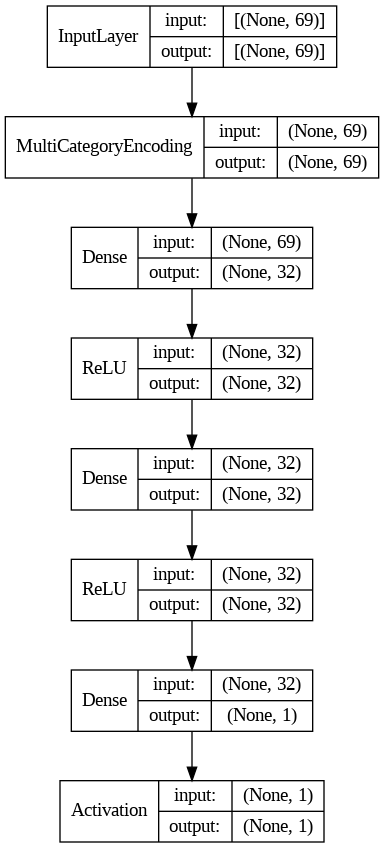

In [56]:
utils.plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [60]:
# дообучаем лучшую модель
history = best_model.fit(
    x_train_01,
    y_train,
    epochs=20,
    validation_split=0.4
)


Epoch 1/20
4/4 [==============================] - 0s 50ms/step - loss: 0.1218 - accuracy: 0.9720 - val_loss: 0.1305 - val_accuracy: 0.9722
Epoch 2/20
4/4 [==============================] - 0s 31ms/step - loss: 0.1212 - accuracy: 0.9720 - val_loss: 0.1301 - val_accuracy: 0.9722
Epoch 3/20
4/4 [==============================] - 0s 30ms/step - loss: 0.1201 - accuracy: 0.9720 - val_loss: 0.1303 - val_accuracy: 0.9722
Epoch 4/20
4/4 [==============================] - 0s 31ms/step - loss: 0.1198 - accuracy: 0.9720 - val_loss: 0.1305 - val_accuracy: 0.9722
Epoch 5/20
4/4 [==============================] - 0s 46ms/step - loss: 0.1192 - accuracy: 0.9720 - val_loss: 0.1304 - val_accuracy: 0.9722
Epoch 6/20
4/4 [==============================] - 0s 32ms/step - loss: 0.1196 - accuracy: 0.9720 - val_loss: 0.1295 - val_accuracy: 0.9722
Epoch 7/20
4/4 [==============================] - 0s 32ms/step - loss: 0.1190 - accuracy: 0.9720 - val_loss: 0.1291 - val_accuracy: 0.9722
Epoch 8/20
4/4 [===========

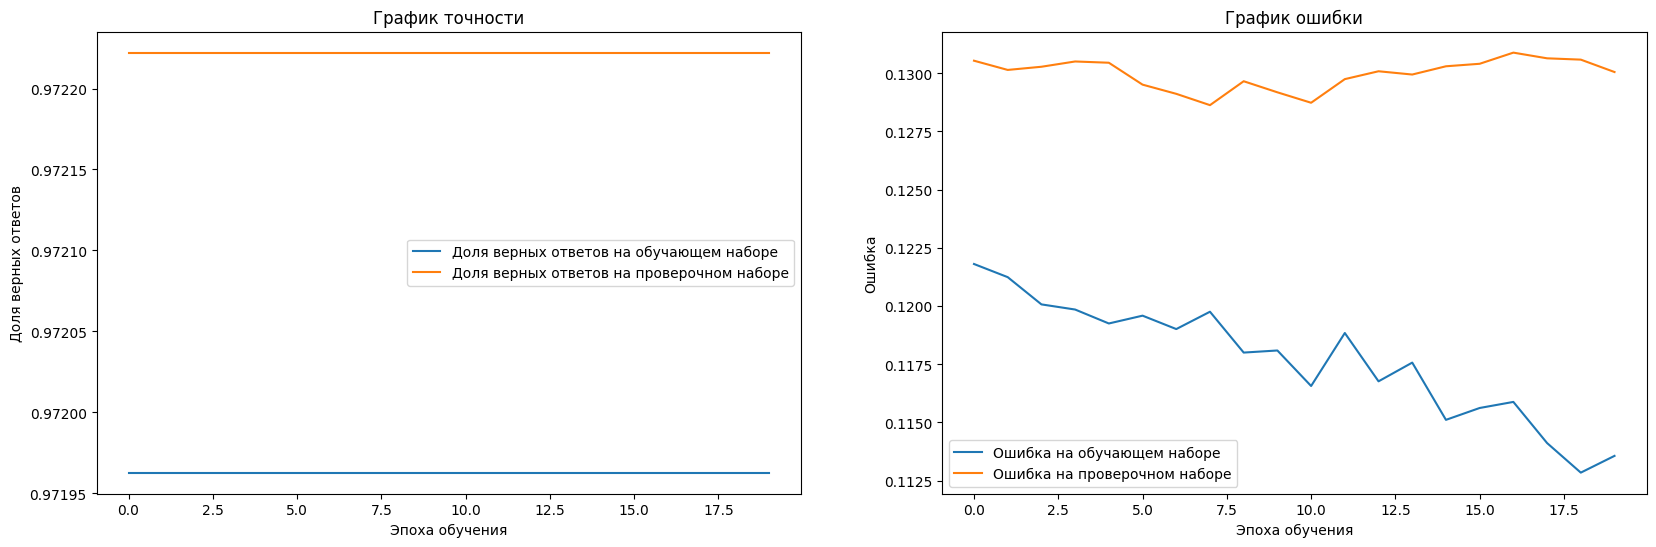

In [61]:
plot_history(history)

4/4 [==============================] - 0s 6ms/step


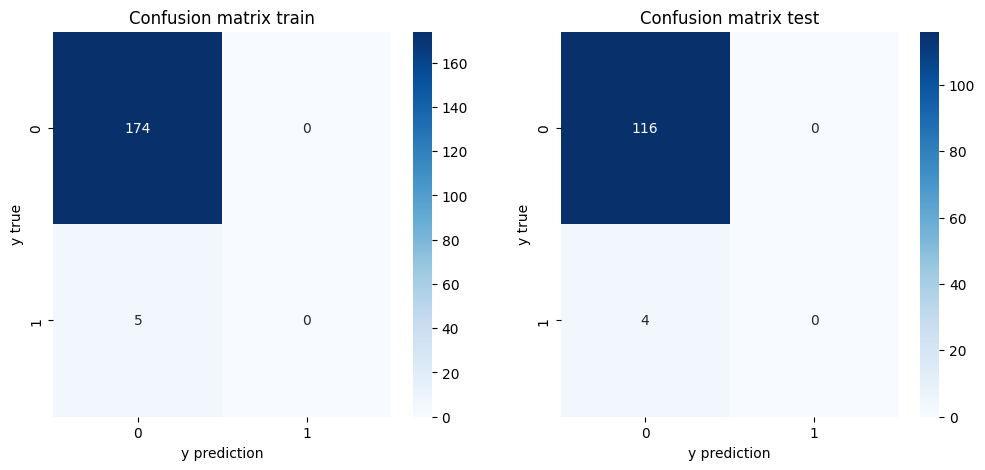

In [62]:
Error_matrix (best_model, x_train_01, x_test_01)



## AutoML модель с двумя входами

In [ ]:
# Инициализация модели с несколькими входными и выходными данными.
model_2 = ak.AutoModel(
    inputs=[ak.TextInput(), ak.StructuredDataInput()],
    outputs=[
        ak.ClassificationHead(loss="mean_squared_error", metrics=["accuracy"])
    ],
    overwrite=True,
    max_trials=10,
    objective='val_accuracy',
    directory=directory_AUtoML,
    project_name='Input_2'
)

# Обучаем модель на подготовленных данных.
model_2.fit(
    [x_train_text, x_train_01],
    y_train,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

Trial 10 Complete [00h 00m 14s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 39s
Epoch 1/10
6/6 [==============================] - 2s 23ms/step - loss: 22.4227 - accuracy: 0.9721
Epoch 2/10
6/6 [==============================] - 0s 22ms/step - loss: 6.1368 - accuracy: 0.7374
Epoch 3/10
6/6 [==============================] - 0s 24ms/step - loss: 0.9451 - accuracy: 0.4078
Epoch 4/10
6/6 [==============================] - 0s 25ms/step - loss: 0.6843 - accuracy: 0.5419
Epoch 5/10
6/6 [==============================] - 0s 24ms/step - loss: 0.7752 - accuracy: 0.5363
Epoch 6/10
6/6 [==============================] - 0s 25ms/step - loss: 0.5238 - accuracy: 0.5531
Epoch 7/10
6/6 [==============================] - 0s 22ms/step - loss: 0.2275 - accuracy: 0.6592
Epoch 8/10
6/6 [==============================] - 0s 21ms/step - loss: 0.1315 - accuracy: 0.9106
Epoch 9/10
6/6 [==============================] - 0s 19ms/step - loss: 0.1382 - accuracy: 0.9553
Epoch 10/10
6

In [ ]:
best_model_2 = model_2.export_model()

In [ ]:
#Запись модели на диск
try:
    best_model_2.save("model_autokeras_in2", save_format="tf")
except Exception:
    best_model_2.save("model_autokeras_in2.h5")

In [ ]:
best_model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 expand_last_dim (ExpandLas  (None, 1)                    0         ['input_1[0][0]']             
 tDim)                                                                                            
                                                                                                  
 text_vectorization (TextVe  (None, 64)                   0         ['expand_last_dim[0][0]']     
 ctorization)                                                                                     
                                                                                              

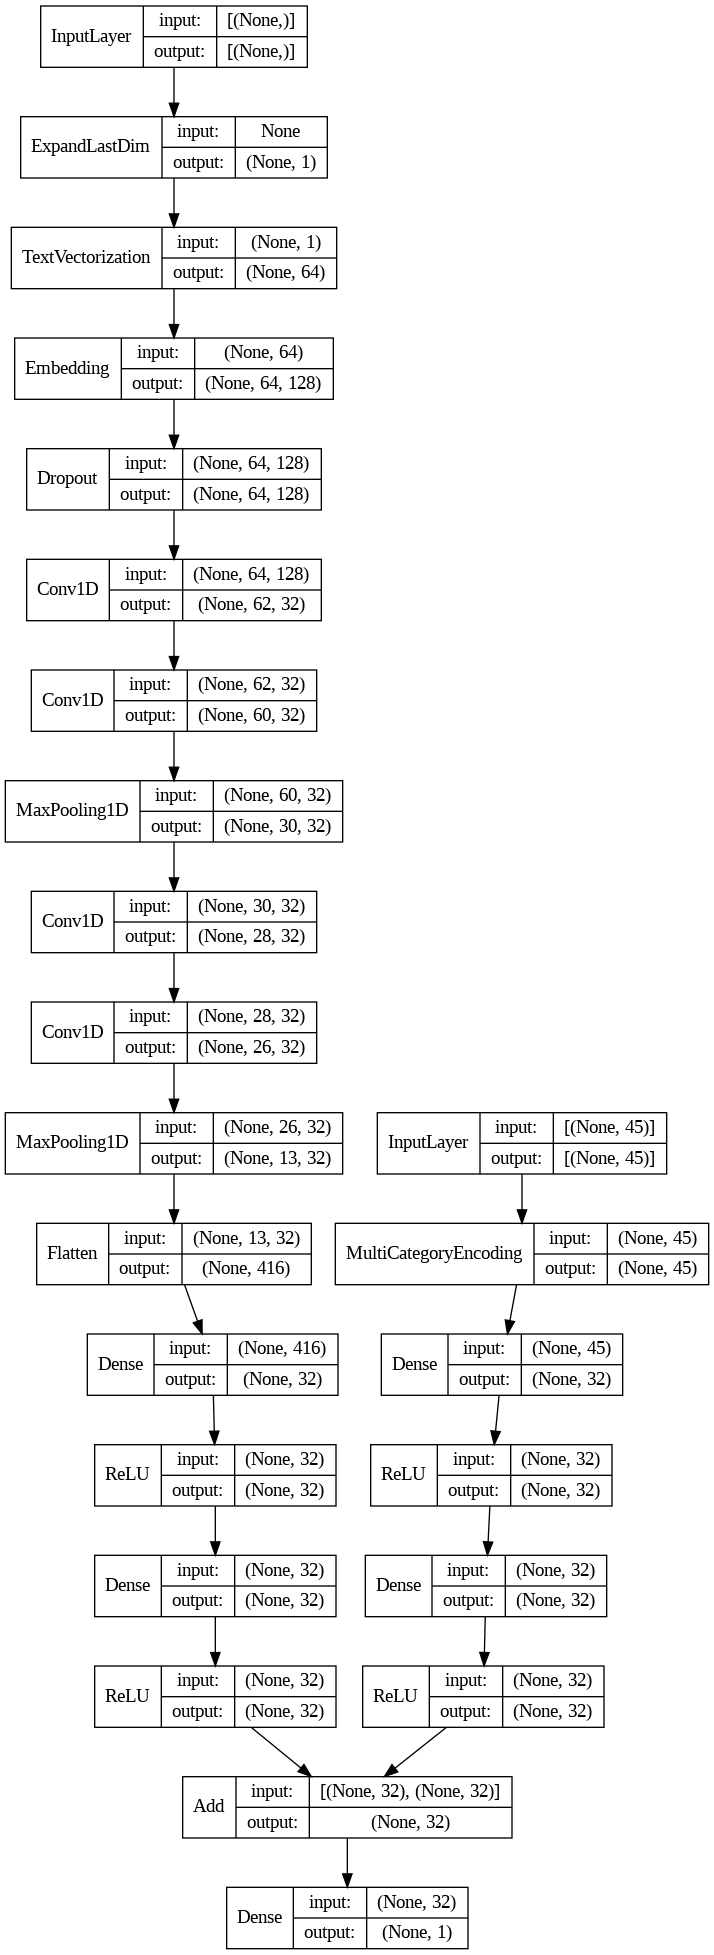

In [ ]:
utils.plot_model(best_model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
loaded_model = load_model("model_autokeras_in2", custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
# дообучаем лучшую модель
history = loaded_model.fit(
    [x_train_text, x_train_01],
    y_train,
    epochs=10,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
5/5 [==============================] - 3s 165ms/step - loss: 0.0870 - accuracy: 0.9580 - val_loss: 0.1168 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 0s 31ms/step - loss: 0.0619 - accuracy: 0.9580 - val_loss: 0.0330 - val_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 0s 30ms/step - loss: 0.0539 - accuracy: 0.9650 - val_loss: 0.0511 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 0s 29ms/step - loss: 0.0416 - accuracy: 0.9650 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 0s 32ms/step - loss: 0.0339 - accuracy: 0.9650 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 0s 30ms/step - loss: 0.0289 - accuracy: 0.9650 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 0s 48ms/step - loss: 0.0246 - accuracy: 0.9720 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 8/10
5/5 [==========

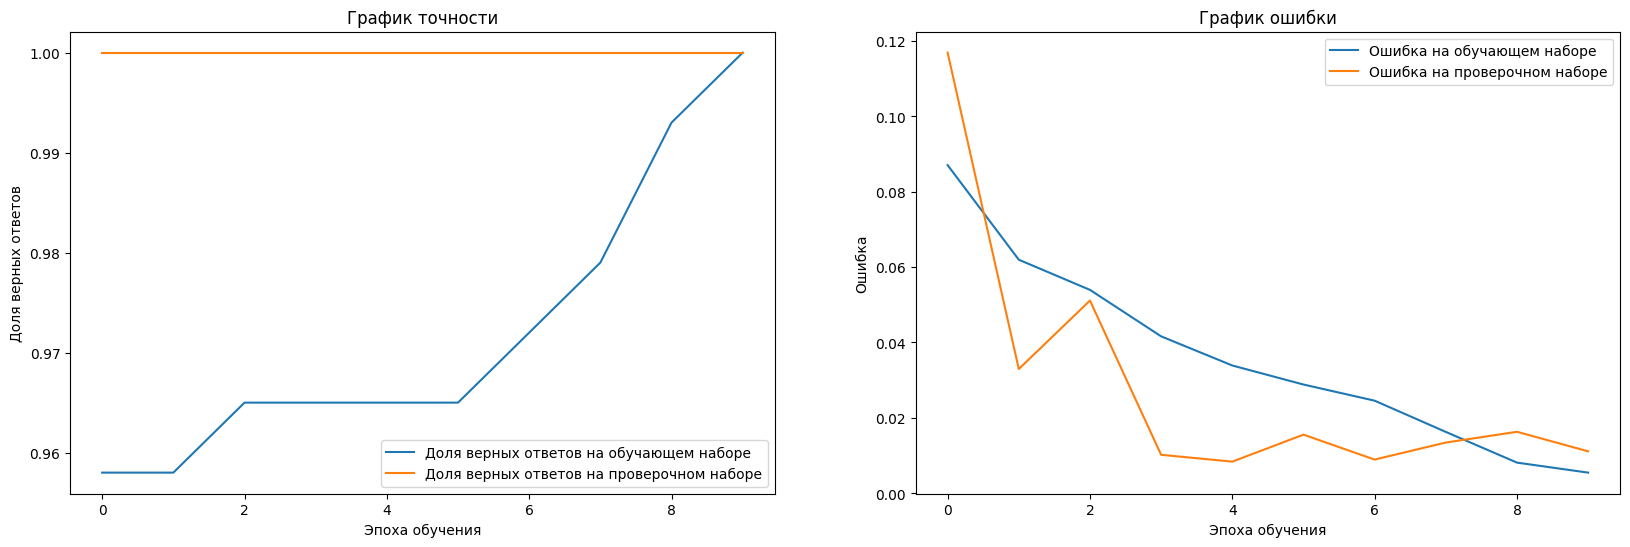

In [ ]:
plot_history(history)

4/4 [==============================] - 0s 11ms/step


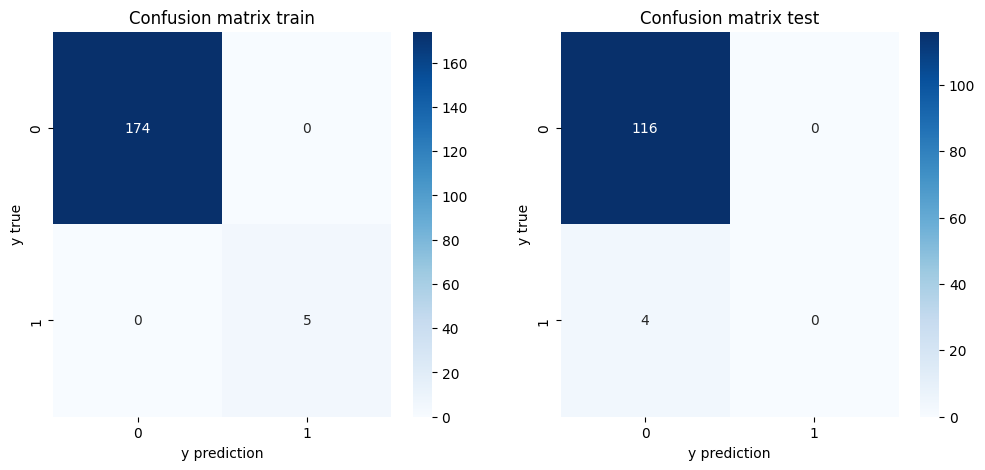

In [ ]:
Error_matrix_2 (loaded_model, x_train_text, x_test_text, x_train_01, x_test_01)

# Создание модели 1 вход


In [ ]:
model_r1 = Sequential()

model_r1.add(Dense(45, input_dim=x_train_01.shape[1], activation='relu'))
model_r1.add(Dense(20, activation='relu'))
model_r1.add(Dense(1, activation='sigmoid'))


# Скомпилируем модель
model_r1.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# и выведем ее аржитектуру
model_r1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 45)                2070      
                                                                 
 dense_1 (Dense)             (None, 20)                920       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3011 (11.76 KB)
Trainable params: 3011 (11.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# дообучаем лучшую модель
history = model_r1.fit(
    x_train_01,
    y_train,
    batch_size=8,
    epochs=20,
    validation_split=0.4
)

Epoch 1/20
14/14 [==============================] - 1s 37ms/step - loss: 0.1461 - accuracy: 0.7009 - val_loss: 0.1219 - val_accuracy: 0.9583
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 0.0952 - accuracy: 0.9626 - val_loss: 0.0808 - val_accuracy: 0.9722
Epoch 3/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0592 - accuracy: 0.9720 - val_loss: 0.0503 - val_accuracy: 0.9722
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.0387 - accuracy: 0.9720 - val_loss: 0.0364 - val_accuracy: 0.9722
Epoch 5/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0305 - accuracy: 0.9720 - val_loss: 0.0321 - val_accuracy: 0.9722
Epoch 6/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0281 - accuracy: 0.9720 - val_loss: 0.0304 - val_accuracy: 0.9722
Epoch 7/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0270 - accuracy: 0.9720 - val_loss: 0.0296 - val_accuracy: 0.9722
Epoch 8/20
14/14 [=

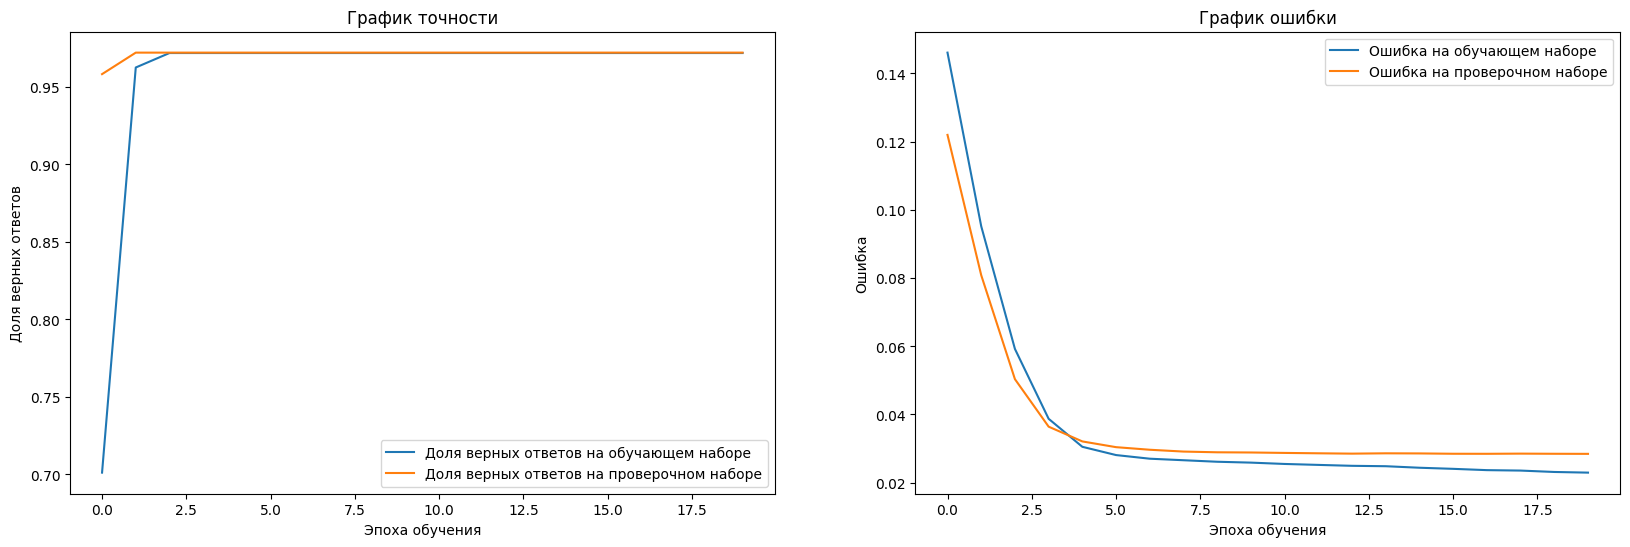

In [ ]:
plot_history(history)

4/4 [==============================] - 0s 2ms/step


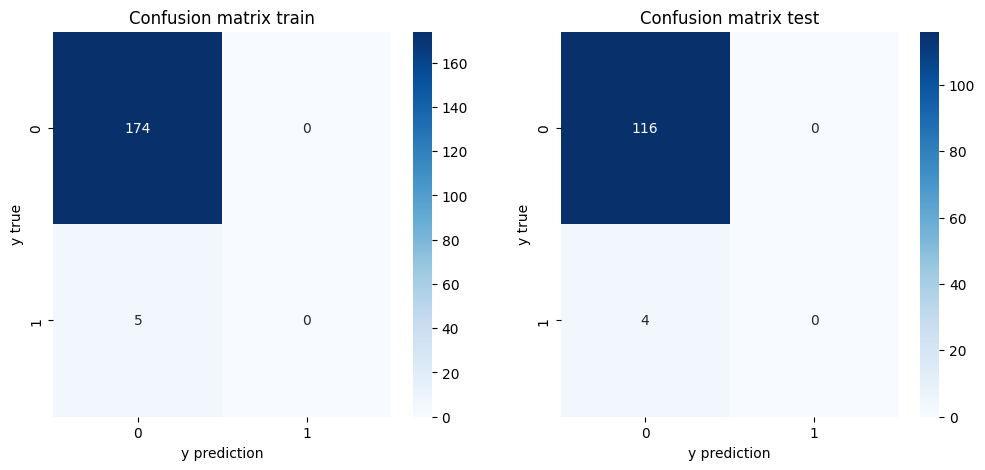

In [ ]:
Error_matrix (model_r1, x_train_01, x_test_01)

In [ ]:
pred = model_r1.predict( x_test_01)
for i in range(len(pred[:10])): # Выводим результаты
    print(' Предсказание - ',pred[i],'   Результат - ', y_test[i])
#    print('Данные -',x_test_01[i],'  Предсказание - ',pred[i],'   Результат - ', y_test[i])

4/4 [==============================] - 0s 2ms/step
 Предсказание -  [1.22171645e-14]    Результат -  0
 Предсказание -  [0.00330555]    Результат -  0
 Предсказание -  [0.21877302]    Результат -  0
 Предсказание -  [0.]    Результат -  0
 Предсказание -  [5.4380084e-11]    Результат -  1
 Предсказание -  [1.12794355e-14]    Результат -  0
 Предсказание -  [7.6749385e-11]    Результат -  0
 Предсказание -  [5.758638e-13]    Результат -  0
 Предсказание -  [0.]    Результат -  0
 Предсказание -  [0.02233166]    Результат -  0
